In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
PROC = Path("../data/processed/AAPL_clean.csv")
df = pd.read_csv(PROC, parse_dates=["Date"], index_col="Date")

In [3]:
df=df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

In [4]:
df

,ds,y
0,2017-11-27,40.809978
1,2017-11-28,40.570877
2,2017-11-29,39.729301
3,2017-11-30,40.284885
4,2017-12-01,40.097347
...,...,...
1957,2025-09-11,230.029999
1958,2025-09-12,234.070007
1959,2025-09-15,236.699997
1960,2025-09-16,238.149994


In [5]:
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:].copy()

In [6]:
from neuralprophet import NeuralProphet

m = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_changepoints=30,
    epochs=600,
    trend_reg=1,   # increase penalty on extreme trends
)

metrics=m.fit(train_df, freq='B')

c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning_fabric\__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_fr

Finding best initial lr:   0%|          | 0/230 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning_fabric\utilities\cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Training: 0it [00:00, ?it/s]

In [7]:
future = m.make_future_dataframe(train_df, periods=len(test_df))
forecast = m.predict(future)


WARNING - (py.warnings._showwarnmsg) - c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.112% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Predicting: 50it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [8]:
preds = forecast.set_index("ds")["yhat1"].iloc[-len(test_df):]

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_true = test_df['y'].values   # actual values
y_pred = forecast['yhat1'].iloc[-len(test_df):].values  # predicted values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 25.1854
RMSE: 30.8166


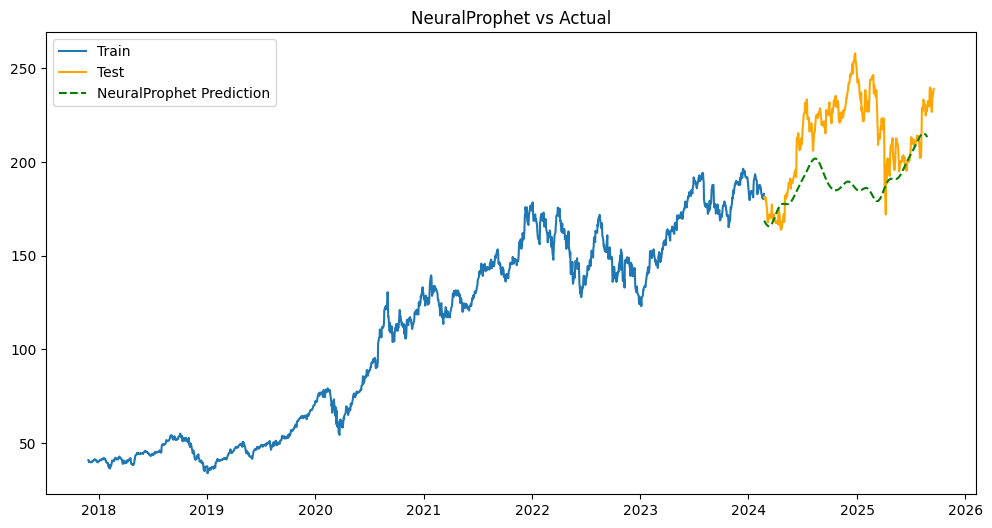

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(train_df["ds"], train_df["y"], label="Train")
plt.plot(test_df["ds"], test_df["y"], label="Test", color="orange")
plt.plot(preds.index, preds.values, label="NeuralProphet Prediction", color="green", linestyle="--")
plt.title("NeuralProphet vs Actual")
plt.legend()
plt.show()

In [11]:
import sys
sys.path.append("../")
from src.utils.logger import log_metrics
log_metrics("NeuralProphet", mae, rmse)

Metrics logged to ../data/models/mertics.csv
